In [2]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/zeya/Git/kth-machine_learning/mlfs-book
HopsworksSettings initialized!


In [3]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 25, 22, 41, 56, 603685)

In [4]:
project = hopsworks.login(engine="python",project="airqualitypredictionssr")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-25 22:41:56,613 INFO: Initializing external client
2025-11-25 22:41:56,613 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-25 22:41:57,312 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-25 22:41:58,061 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279183


In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-25 22:42:00,479 INFO: There is no parent information


Downloading: 0.000%|          | 0/160287 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18630 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/374972 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/air_quality_xgboost_model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='1.3689719E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.23s) 


,date,pm25,country,city,street,url
0,2019-07-24 00:00:00+00:00,103.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
1,2020-12-05 00:00:00+00:00,8.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
2,2021-07-17 00:00:00+00:00,31.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
3,2022-12-22 00:00:00+00:00,4.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
4,2021-06-18 00:00:00+00:00,10.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
...,...,...,...,...,...,...
2666,2025-11-21 00:00:00+00:00,7.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
2667,2025-11-23 00:00:00+00:00,4.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
2668,2025-11-20 00:00:00+00:00,9.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147
2669,2025-11-22 00:00:00+00:00,2.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147


In [8]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.65s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-26 00:00:00+00:00,23.200001,0.0,5.116561,140.710617,western
1,2025-11-28 00:00:00+00:00,21.750000,0.0,15.790833,133.152405,western
2,2025-11-30 00:00:00+00:00,24.650000,0.0,12.031756,128.927551,western
3,2025-11-27 00:00:00+00:00,22.700001,0.0,30.364031,169.755966,western
4,2025-11-29 00:00:00+00:00,22.450001,0.0,18.079027,144.727493,western
5,2025-12-01 00:00:00+00:00,28.299999,0.0,9.504273,114.623550,western


In [9]:
weather_fg

In [10]:
# 假设 air_quality_df 已经有 ['date','pm25','city','country','street']
# 按城市排序并生成滞后特征
lag_days = [1, 2, 3]

# 确保按日期排序
air_quality_df = air_quality_df.sort_values(by=['city','date'])

for lag in lag_days:
    air_quality_df[f'pm25_lag{lag}'] = air_quality_df.groupby('city')['pm25'].shift(lag)

# 删除含有NaN的行（因为前几天的滞后特征会产生NaN）
air_quality_df = air_quality_df.dropna().reset_index(drop=True)
air_quality_df

,date,pm25,country,city,street,url,pm25_lag1,pm25_lag2,pm25_lag3
0,2017-11-27 00:00:00+00:00,24.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,18.0,14.0,15.0
1,2017-11-28 00:00:00+00:00,29.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,24.0,18.0,14.0
2,2017-11-29 00:00:00+00:00,26.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,29.0,24.0,18.0
3,2017-11-30 00:00:00+00:00,14.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,26.0,29.0,24.0
4,2017-12-01 00:00:00+00:00,11.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,14.0,26.0,29.0
...,...,...,...,...,...,...,...,...,...
2663,2025-11-21 00:00:00+00:00,7.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,9.0,8.0,3.0
2664,2025-11-22 00:00:00+00:00,2.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,7.0,9.0,8.0
2665,2025-11-23 00:00:00+00:00,4.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,2.0,7.0,9.0
2666,2025-11-24 00:00:00+00:00,8.0,australia,western,kalgoorlie,https://api.waqi.info/feed/@10147,4.0,2.0,7.0


In [12]:
# Create a new version of the feature group (V2)
air_quality_v2 = fs.get_or_create_feature_group(
    name='air_quality_lagged_3_days',
    version=1,
    description='Air quality with lag features (1, 2, 3 days)',
    primary_key=['city', 'date'],
    event_time='date'
)

# Insert the new data
air_quality_v2.insert(air_quality_df, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279183/fs/1283141/fg/1783119


Uploading Dataframe: 100.00% |██████████| Rows 2668/2668 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_lagged_3_days_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279183/jobs/named/air_quality_lagged_3_days_1_offline_fg_materialization/executions
2025-11-25 22:45:18,213 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-25 22:45:21,394 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-25 22:47:00,113 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-25 22:47:00,280 INFO: Waiting for log aggregation to finish.
2025-11-25 22:47:08,894 INFO: Execution finished successfully.


(Job('air_quality_lagged_3_days_1_offline_fg_materialization', 'SPARK'), None)

In [35]:
# 选择天气特征
weather_features = ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']

# 合并天气特征
selected_features = air_quality_fg.select(['pm25', 'date', 'city']).join(weather_fg.select(weather_features + ['city', 'date']), on=['city','date'])
df = selected_features.read()

df = df.rename(columns={
    'weather_temperature_2m_mean': 'temperature_2m_mean',
    'weather_precipitation_sum': 'precipitation_sum',
    'weather_wind_speed_10m_max': 'wind_speed_10m_max',
    'weather_wind_direction_10m_dominant': 'wind_direction_10m_dominant'
})

# 合并滞后特征
df = pd.merge(df, air_quality_df[['date','city'] + [f'pm25_lag{lag}' for lag in lag_days]], on=['date','city'])

# 特征列
X_cols = weather_features + [f'pm25_lag{lag}' for lag in lag_days]
y_cols = ['pm25']
X = df[X_cols]
y = df[y_cols]

2025-11-25 21:49:56,078 WARNING: Ambiguous features detected during query construction.The feature `date` is present in feature groups ['air_quality version 1', 'weather version 1']. The feature `city` is present in feature groups ['air_quality version 1', 'weather version 1']. Automatically prefixing features selected using these feature groups with the feature group name.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.15s) 


In [37]:
X

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,pm25_lag1,pm25_lag2,pm25_lag3
0,32.677834,0.0,27.887802,92.115875,21.0,18.0,17.0
1,26.827835,1.0,21.068459,359.999878,18.0,20.0,28.0
2,29.952837,0.0,25.570139,115.702568,9.0,12.0,12.0
3,19.515333,0.0,25.984919,116.075294,17.0,24.0,20.0
4,23.575750,0.0,26.932714,83.247055,22.0,20.0,31.0
...,...,...,...,...,...,...,...
2648,23.377832,0.0,20.116560,109.647781,4.0,5.0,4.0
2649,26.015333,0.0,20.721901,239.795807,5.0,8.0,6.0
2650,19.959085,0.0,13.432632,209.345703,4.0,3.0,4.0
2651,19.819500,0.0,22.483435,107.242432,3.0,3.0,2.0


In [38]:
from sklearn.model_selection import train_test_split

# setting a date to split train and test sets
test_start = "2025-05-01"
train_df = df[df['date'] < test_start]
test_df = df[df['date'] >= test_start]

X_train = train_df[X_cols]
y_train = train_df[y_cols]
X_test = test_df[X_cols]
y_test = test_df[y_cols]

In [39]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_regressor = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE after adding lag features:", mse)
print("R squared after adding lag features:", r2)

2025-11-25 21:51:08,741 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-25 21:51:08,742 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-25 21:51:08,742 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-25 21:51:08,744 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-25 21:51:08,745 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-11-25 21:51:08,745 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spar

2025-11-25 21:51:18,439 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



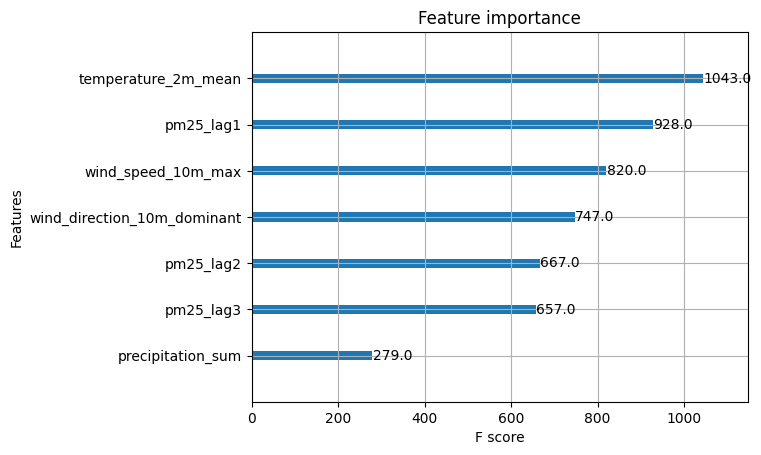

In [40]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(xgb_regressor, importance_type='weight', max_num_features=10)
plt.show()

In [44]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/air_quality_xgboost_model_C.json")

mr = project.get_model_registry()
# Convert metrics to Python float
metrics_dict = {
    "MSE": float(mse),
    "R2": float(r2)
}

model_v2 = mr.python.create_model(
    name="air_quality_xgboost_model_C",
    version=1,
    metrics=metrics_dict,
    description="XGBoost model with lag_1, lag_2, lag_3 features"
)

# 保存模型 artifact 到 Model Registry
model_v2.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/air_quality_model/air_quality_xg…

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/air_quality_model/air_quality_xg…

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/air_quality_model/images/feature…

Uploading /Users/zeya/Git/kth-machine_learning/mlfs-book/notebooks/airquality/air_quality_model/images/pm25_hi…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279183/models/air_quality_xgboost_model_C/1


Model(name: 'air_quality_xgboost_model_C', version: 1)